# Missingness
- A problem both common and insidious

### Diagnosis: 
- How many rows are missing at least one value?
- What fraction of columns/features are missing values?
- Is there any pattern to the missing values? (What is the missigness regime?)
 - Create a missingness indicator for each feature with missing values, and run pairwise correlations against other features in the dataset. 
 - Compute Pearson correlation strength of model features with count of the number of missing values per observation.

#### Looking at some auxiliary features
- Not expecting to use frac year in the model, but it can be used to test missingness regime

 ### Remedy:
- Use modern multiple imputation technique
- Test different imputation techniques using cross-validation
  - First create a dataset that is close to MCAR (missing completely at random).
  - Mask out a portion of known datapoints, then build models over and over again on different random partitions of the dataset.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

# custom tools
import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
# import data_munging_tools as dmt
import model_fitting_tools as mft

In [2]:
full_df =  pd.read_csv("../data/full_df.tsv", sep="\t", index_col="api")

In [3]:
def count_missings(df):
    percent_missing_df = (df.isnull().sum() / full_df.shape[0] * 100).round(2).to_frame().rename(columns={0: "percent_missing"})
    return percent_missing_df

In [4]:
percent_missing_df = count_missings(full_df)
percent_missing_df

,percent_missing
bakken_isopach_ft,0.00
data_group,0.00
length,5.11
mean_tvd,0.00
production_liquid_180,0.00
shortest_dist,0.00
spud_year,0.25
stage_spacing,13.94
std_tvd,0.00
surface_lat,0.00


In [5]:
percent_missing_df = count_missings(full_df.query("spud_year > 2009"))
percent_missing_df

,percent_missing
bakken_isopach_ft,0.00
data_group,0.00
length,4.35
mean_tvd,0.00
production_liquid_180,0.00
shortest_dist,0.00
spud_year,0.00
stage_spacing,4.77
std_tvd,0.00
surface_lat,0.00


In [6]:
#TODO this is a problem. haversine is not working properly for about 5% of observations
full_df.query("length != length").shape

(383, 16)

In [7]:
full_df.shape

(7502, 16)

In [11]:
full_df.query("spud_year > 2009").dropna().shape

(5836, 16)

In [12]:
later_df = full_df.copy().query("spud_year > 2009")

In [13]:
later_df.shape

(6518, 16)

In [14]:
missing_fluid = set(later_df.query("total_volume_bbls != total_volume_bbls").index.values)

missing_proppant = set(later_df.query("total_lbs_proppant!= total_lbs_proppant").index.values)

print(f'''
    {len(missing_fluid.union(missing_proppant))} missing either fluid OR proppant,
    {len(missing_fluid.intersection(missing_proppant))} missing both fluid AND proppant,
    {len(missing_fluid - missing_proppant)} missing only fluid
    {len(missing_proppant - missing_fluid)} missing only proppant
    ''')



    353 missing either fluid OR proppant,
    108 missing both fluid AND proppant,
    159 missing only fluid
    86 missing only proppant
    


In [17]:
foi = ["std_tvd", 
       "tvd", 
       "total_lbs_proppant", 
       "total_volume_bbls", 
       "total_num_stages", 
       "spud_year", 
#        "bh_lat", 
#        "bh_lng", 
       "target_formation",
       "production_liquid_180"]

In [18]:
full_df[foi].isnull().sum() / full_df[foi].shape[0]

std_tvd                  0.000000
tvd                      0.000000
total_lbs_proppant       0.141829
total_volume_bbls        0.152359
total_num_stages         0.094641
spud_year                0.002533
target_formation         0.001466
production_liquid_180    0.000000
dtype: float64

In [19]:
null_count_df = full_df[foi].isnull().sum().to_frame().rename(columns={0: "null_count"})

In [20]:
null_count_df.query("null_count > 1").index.tolist()

['total_lbs_proppant',
 'total_volume_bbls',
 'total_num_stages',
 'spud_year',
 'target_formation']

In [21]:
null_flag_df = full_df.copy()

for col in foi:
    null_flag_df[col + "_isnull"] = null_flag_df[col].isnull()

In [22]:
completion_features = \
['total_lbs_proppant',
 'total_volume_bbls',
 'total_num_stages']

In [23]:
null_flag_corr_df = null_flag_df[["surface_lat", "surface_lng", "spud_year"] + [x + "_isnull" for x in completion_features]].corr()

## Missingness of `total_lbs_proppant` is highly correlated (~87%) with missingness of `total_volume_bbls`

In [24]:
null_flag_corr_df

,surface_lat,surface_lng,spud_year,total_lbs_proppant_isnull,total_volume_bbls_isnull,total_num_stages_isnull
surface_lat,1.000000,-0.126848,0.003178,0.006326,-0.002830,-0.040458
surface_lng,-0.126848,1.000000,-0.245711,0.265234,0.258472,0.187109
spud_year,0.003178,-0.245711,1.000000,-0.661677,-0.646359,-0.634365
total_lbs_proppant_isnull,0.006326,0.265234,-0.661677,1.000000,0.867450,0.762675
total_volume_bbls_isnull,-0.002830,0.258472,-0.646359,0.867450,1.000000,0.730929
total_num_stages_isnull,-0.040458,0.187109,-0.634365,0.762675,0.730929,1.000000



## Most features don't have a strong correlation the count of missing values per row, except for the year the well was completed.
- Initially, I only looked at missingness correlations for features I expected to put into the final model, but this was a mistake. If I had stopped there, I would have overlooked an important pattern.
- I wondered whether the missingess had something to do with the age of the well. I first parsed the `spud_date` field to get a year as an integer value.
- For `spud_year` The absolute value of the correlation coefficient is relatively high, above `0.6`.

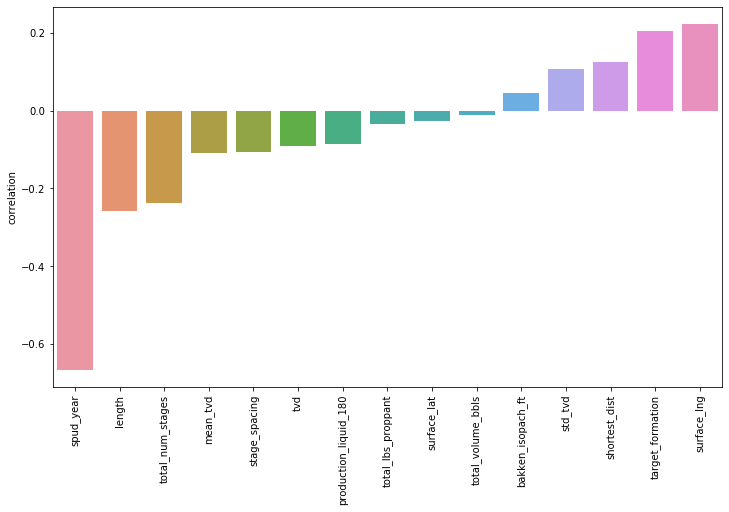

In [25]:
has_nulls_df = full_df.copy().assign(has_nulls= lambda x: pd.isnull(x).sum(axis=1))
correlations = has_nulls_df.corr().sort_values('has_nulls')[['has_nulls']]
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.barplot(x='index', y='has_nulls', 
                 data=correlations.dropna().drop('has_nulls', axis=0).reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('correlation')
plt.show()

### We can further see that if a well is missing proppant, it is far more likely to be an old well. These distros are so obviously divergent, we can conduct a 'visual t-test'. There is a clearly significant difference between the two groups.

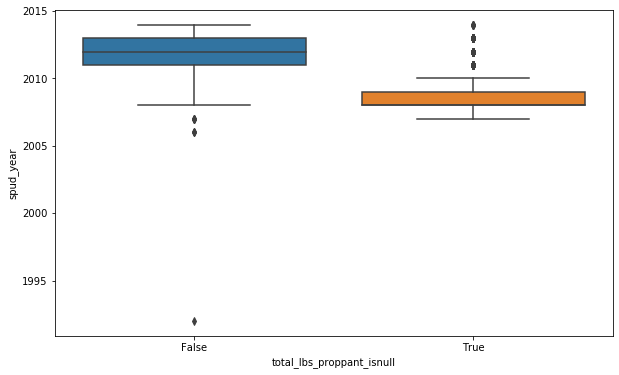

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=null_flag_df, y="spud_year", x="total_lbs_proppant_isnull")

In [27]:
null_flag_df.filter(["total_lbs_proppant_isnull", "spud_year"]).groupby("total_lbs_proppant_isnull").mean()

,spud_year
total_lbs_proppant_isnull,
False,2011.993457
True,2008.738722


In [28]:
vc = full_df.spud_year.value_counts().sort_index().to_frame().rename(columns={"spud_year": "value_counts"})

num_missing_by_year = (full_df.copy()
               .filter(["total_lbs_proppant", "total_volume_bbls", "spud_year"])
               .groupby("spud_year")
               .apply(lambda x: x.isnull().sum())
               .drop("spud_year", axis=1)
               .rename(columns={"total_lbs_proppant": "prop_num_missing",
                               "total_volume_bbls" : "fluid_num_missing"
                               })
               .join(vc)
               .assign(prop_perc_missing = lambda x: x["prop_num_missing"]/ x["value_counts"] * 100,
                       fluid_perc_missing = lambda x: x["fluid_num_missing"]/ x["value_counts"] * 100,
                      )
              )

## Before 2010, most observations (83 - 97% are missing values for fluid and proppant).
- We know two things from our correlation heatmap and preliminary modeling exercise as part of EDA - proppant and fluid are both important features.
- The modern fracking boom didnt really get started until 2009-ish anyway. I think it's reasonable to assume that these just aren't relevant wells when trying to predict future production.
- Furthermore, there just aren't that many of these 'early' (pre-2010) wells.

In [29]:
num_missing_by_year

,prop_num_missing,fluid_num_missing,value_counts,prop_perc_missing,fluid_perc_missing
spud_year,,,,,
1992.0,0,0,1,0.000000,0.000000
2006.0,0,0,3,0.000000,0.000000
2007.0,156,156,161,96.894410,96.894410
2008.0,409,409,433,94.457275,94.457275
2009.0,305,310,367,83.106267,84.468665
2010.0,77,93,848,9.080189,10.966981
2011.0,33,44,1274,2.590267,3.453689
2012.0,43,84,1846,2.329361,4.550379
2013.0,34,40,1966,1.729400,2.034588


### Testing Imputation Methods

In [30]:
# To use this experimental feature, we need to explicitly ask for it:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [31]:
# approx 19% of rows have more than one missing_value
full_df.isnull().sum(axis=1).to_frame().reset_index().rename(columns={0: "count"}).query("count > 1").shape[0] / full_df.shape[0] * 100

17.70194614769395

In [33]:
test_df = (full_df.copy()
     .drop(["data_group"], axis=1)
     .query("spud_year > 2009")
     .dropna()
)

In [34]:
test_df.isnull().sum()

bakken_isopach_ft        0
length                   0
mean_tvd                 0
production_liquid_180    0
shortest_dist            0
spud_year                0
stage_spacing            0
std_tvd                  0
surface_lat              0
surface_lng              0
target_formation         0
total_lbs_proppant       0
total_num_stages         0
total_volume_bbls        0
tvd                      0
dtype: int64

In [35]:
target_col = "production_liquid_180"

In [36]:
X_full, y_full = mft.X_y_split(test_df, target=target_col)

In [37]:
X_full = X_full.values

In [38]:
X_full.shape

(5836, 14)

In [45]:
N_SPLITS = 30

rng = np.random.RandomState(0)

n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=20, random_state=0),
    KNeighborsRegressor(n_neighbors=20)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [I

/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [I

/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/jameshelfrich/miniconda3/envs/my_env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [I

In [49]:
scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
) * -1

scores.head()

Original SimpleImputer               IterativeImputer  \
      Full Data          mean        median    BayesianRidge   
0  4.868183e+08  4.978123e+08  5.003903e+08     4.962371e+08   
1  6.099720e+08  6.177503e+08  6.141101e+08     6.120920e+08   
2  8.126403e+08  8.347138e+08  8.361270e+08     8.119065e+08   
3  6.881095e+08  7.033215e+08  7.025874e+08     6.848500e+08   
4  4.949349e+08  4.994097e+08  5.000640e+08     4.923874e+08   

                                                                 
  DecisionTreeRegressor ExtraTreesRegressor KNeighborsRegressor  
0          4.833728e+08        4.887841e+08        4.947586e+08  
1          6.138911e+08        6.087508e+08        6.189274e+08  
2          8.242105e+08        8.192034e+08        8.212259e+08  
3          7.053056e+08        6.870434e+08        7.153228e+08  
4          4.977819e+08        5.120524e+08        5.031379e+08

Text(0, 0.5, 'MAE (smaller is better)')

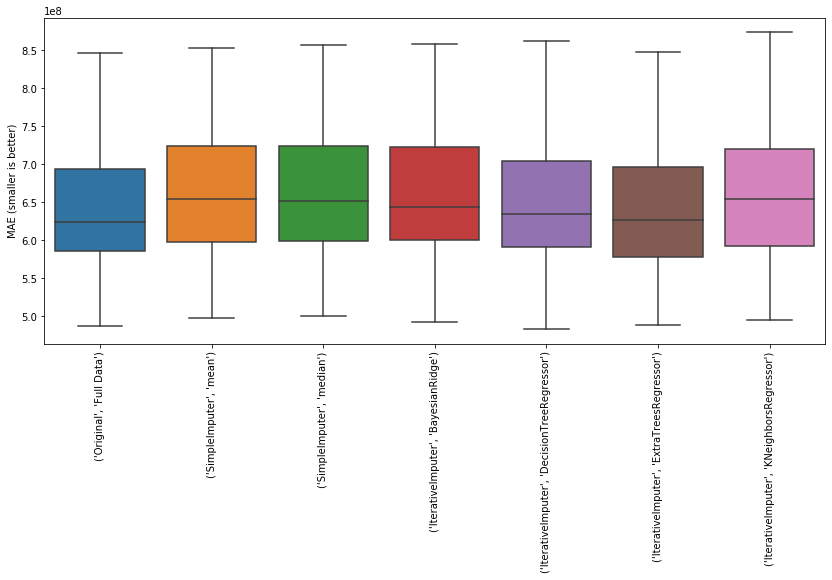

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=scores)
for item in ax.get_xticklabels():
        item.set_rotation(90)
ax.set_ylabel("MAE (smaller is better)")